<a href="https://colab.research.google.com/github/HatoonAloqaily/Movie_Recommendation_System/blob/main/CS492Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as math
import time 
import re # python regular expresion library to clean titles
import seaborn as sbn


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving netflix.csv to netflix.csv


In [ ]:
movies = pd.read_csv('netflix.csv')
# convert the numeric columns to datetime so we can apply the tfidf
movies["date_added"] = pd.to_datetime(movies['date_added'])
movies['year'] = movies['date_added'].dt.year
movies['month'] = movies['date_added'].dt.month
movies['day'] = movies['date_added'].dt.day

# we will also convert the other columns because they have missing values
movies['directors'] = movies['director'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
movies['categories'] = movies['listed_in'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
movies['actors'] = movies['cast'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])
movies['countries'] = movies['country'].apply(lambda l: [] if pd.isna(l) else [i.strip() for i in l.split(",")])

movies.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year,month,day,directors,categories,actors,countries
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019.0,9.0,9.0,"[Richard Finn, Tim Maltby]","[Children & Family Movies, Comedies]","[Alan Marriott, Andrew Toth, Brian Dobson, Col...","[United States, India, South Korea, China]"
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,2016-09-09,2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016.0,9.0,9.0,[],[Stand-Up Comedy],[Jandino Asporaat],[United Kingdom]
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2018-09-08,2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018.0,9.0,8.0,[],[Kids' TV],"[Peter Cullen, Sumalee Montano, Frank Welker, ...",[United States]
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,2018-09-08,2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...,2018.0,9.0,8.0,[],[Kids' TV],"[Will Friedle, Darren Criss, Constance Zimmer,...",[United States]
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...,2017.0,9.0,8.0,[Fernando Lebrija],[Comedies],"[Nesta Cooper, Kate Walsh, John Michael Higgin...",[United States]


In [ ]:
# Build the tfidf matrix with the descriptions and clean the stop words in dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import MiniBatchKMeans

start_time = time.time()
text_content = movies['description']
vector = TfidfVectorizer(max_df=0.4, min_df=1,stop_words='english',lowercase=True,use_idf=True,norm=u'l2',smooth_idf=True)
tfidf = vector.fit_transform(text_content)
# then we will cluster the description of our data to find the similarity of it too
k = 200
kmeans = MiniBatchKMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:,::-1]
terms = vector.get_feature_names()

# we will add another column that cluster the dataset based on the description
request_transform = vector.transform(movies['description'])
movies['cluster'] = kmeans.predict(request_transform) 

movies['cluster'].value_counts().head()   # value count will show the high occournce of movies 


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


99     4074
7      1167
6       238
103     226
37      152
Name: cluster, dtype: int64

In [ ]:
# use tfidf to calculate the similarity 
def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [index for index in related_docs_indices][0:top_n] 

In [ ]:
# here will creat a graph of movies dataset and iterate through all the rows 
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in movies.iterrows():
    if (i%1000==0):
        print(" iter {} -- {} seconds --".format(i,time.time() - start_time))
    G.add_node(rowi['title'],key=rowi['show_id'],label="MOVIE",mtype=rowi['type'],rating=rowi['rating'])
#    G.add_node(rowi['cluster'],label="CLUSTER")
#    G.add_edge(rowi['title'], rowi['cluster'], label="DESCRIPTION")
    for element in rowi['actors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="ACTED_IN")
    for element in rowi['categories']:
        G.add_node(element,label="CATEGORY")
        G.add_edge(rowi['title'], element, label="CATEGORY_IN")
    for element in rowi['directors']:
        G.add_node(element,label="PERSON")
        G.add_edge(rowi['title'], element, label="DIRECTED_IN")
    for element in rowi['countries']:
        G.add_node(element,label="COUNTRY")
        G.add_edge(rowi['title'], element, label="COUNTRY_IN")
    
    indices = find_similar(tfidf, i, top_n = 5)
    snode="Sim("+rowi['title'][:15].strip()+")"        
    G.add_node(snode,label="SIMILAR")
    G.add_edge(rowi['title'], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, movies['title'].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))  

 iter 0 -- 0.02897477149963379 seconds --
 iter 1000 -- 8.656571626663208 seconds --
 iter 2000 -- 16.257611751556396 seconds --
 iter 3000 -- 23.290460348129272 seconds --
 iter 4000 -- 26.97042465209961 seconds --
 iter 5000 -- 32.94375705718994 seconds --
 iter 6000 -- 36.646517753601074 seconds --
 finish -- 37.52045679092407 seconds --


In [ ]:
# to know the length of any category of nodes, we can write any two movies to see the length between them 
nx.dijkstra_path_length(G, "Ocean's Twelve", "Ocean's Thirteen")

2

In [ ]:
def adj_nodes(list_in):
    sub_graph=set()
    for x in list_in:
        sub_graph.add(x)
        for y in G.neighbors(x):        
                sub_graph.add(y)
    return list(sub_graph)
def draw_sub_graph(sub_graph, size='s'):
    subgraph = G.subgraph(sub_graph)
    colors=[]
    for e in subgraph.nodes():
        if G.nodes[e]['label']=="MOVIE":
            colors.append('pink')
        elif G.nodes[e]['label']=="PERSON":
            colors.append('lightblue')
        elif G.nodes[e]['label']=="CATEGORY":
            colors.append('purple')
        elif G.nodes[e]['label']=="COUNTRY":
            colors.append('plum')
        elif G.nodes[e]['label']=="SIMILAR":
            colors.append('gold')    
        elif G.nodes[e]['label']=="CLUSTER":
            colors.append('gold')

    if size == 's':
        plt.figure(figsize=(8, 8))
    else:
        plt.figure(figsize=(15, 15))
    nx.draw(subgraph, with_labels=True, font_size=12,
            node_color=colors, edge_color='#c4c2be')
    plt.show()

In [ ]:
nod =G.number_of_nodes()
edg = G.number_of_edges()
print("Number of nodes: ", nod)
print("Number of edges: ", edg)

Number of nodes:  42949
Number of edges:  106506


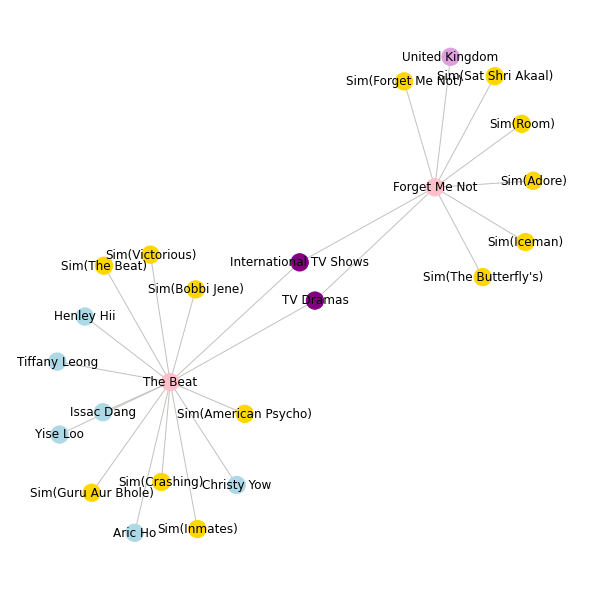

In [ ]:
# see the subgraph if two movies that will give us a look of the connections between them 
list_in=["Forget Me Not","The Beat"]
sub_graph = adj_nodes(list_in)
draw_sub_graph(sub_graph)

In [ ]:
deg = nx.number_of_edges(G)
print("Number of degree: ", deg)

Number of degree:  106506


In [ ]:
def get_recommendation(root):
    commons_dict = {}
    for x in G.neighbors(root):
        for y in G.neighbors(x):
            if y == root:
                continue
            if G.nodes[y]['label'] == 'MOVIE':
                commons = commons_dict.get(y)
                if commons == None:
                    commons_dict.update({y: [x]})
                else:
                    commons.append(x)
                    commons_dict.update({y: commons})
    movies = []
    weight = []
    for (key, values) in commons_dict.items():
        w = 0.0
        for e in values:
            w = w + 1 / math.log(G.degree(e))
        movies.append(key)
        weight.append(w)

    result = pd.Series(data=np.array(weight), index=movies)
    result.sort_values(inplace=True, ascending=False)
    return result

def recommend(input_movie):
    print("-"*40+"\n\n Movie: "+input_movie+"\n\n"+"-"*40)

    list_in = [input_movie]
    sub_graph = adj_nodes(list_in)
    draw_sub_graph(sub_graph)

    result = get_recommendation(input_movie)
    print(result.head())

    print ("\n")
    print("-"*100+"\n\n Other Movie Recommendations")
    # print ("\n")
    print("-"*100)

    reco=list(result.index[:4].values)
    reco.extend([input_movie])
    sub_graph = adj_nodes(reco)
    draw_sub_graph(sub_graph, size='w')

----------------------------------------

 Movie: Stranger Things

----------------------------------------


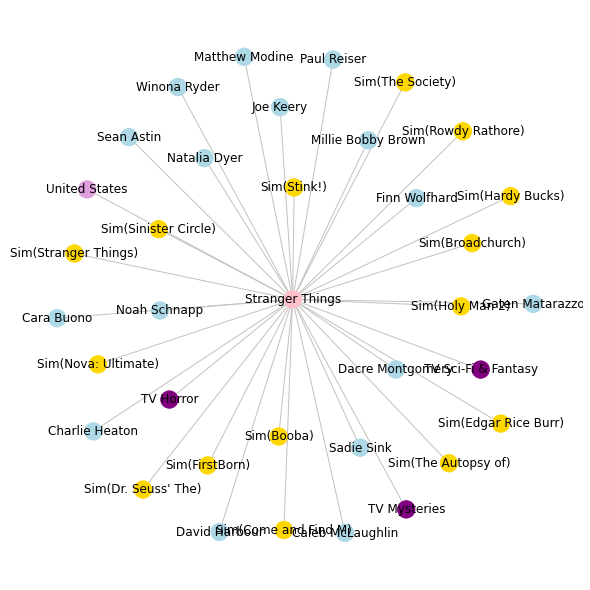

Beyond Stranger Things           14.368296
Rowdy Rathore                     2.091364
Kicking and Screaming             1.569881
How to Make an American Quilt     1.569881
Prank Encounters                  1.288116
dtype: float64


----------------------------------------------------------------------------------------------------

 Other Movie Recommendations
----------------------------------------------------------------------------------------------------


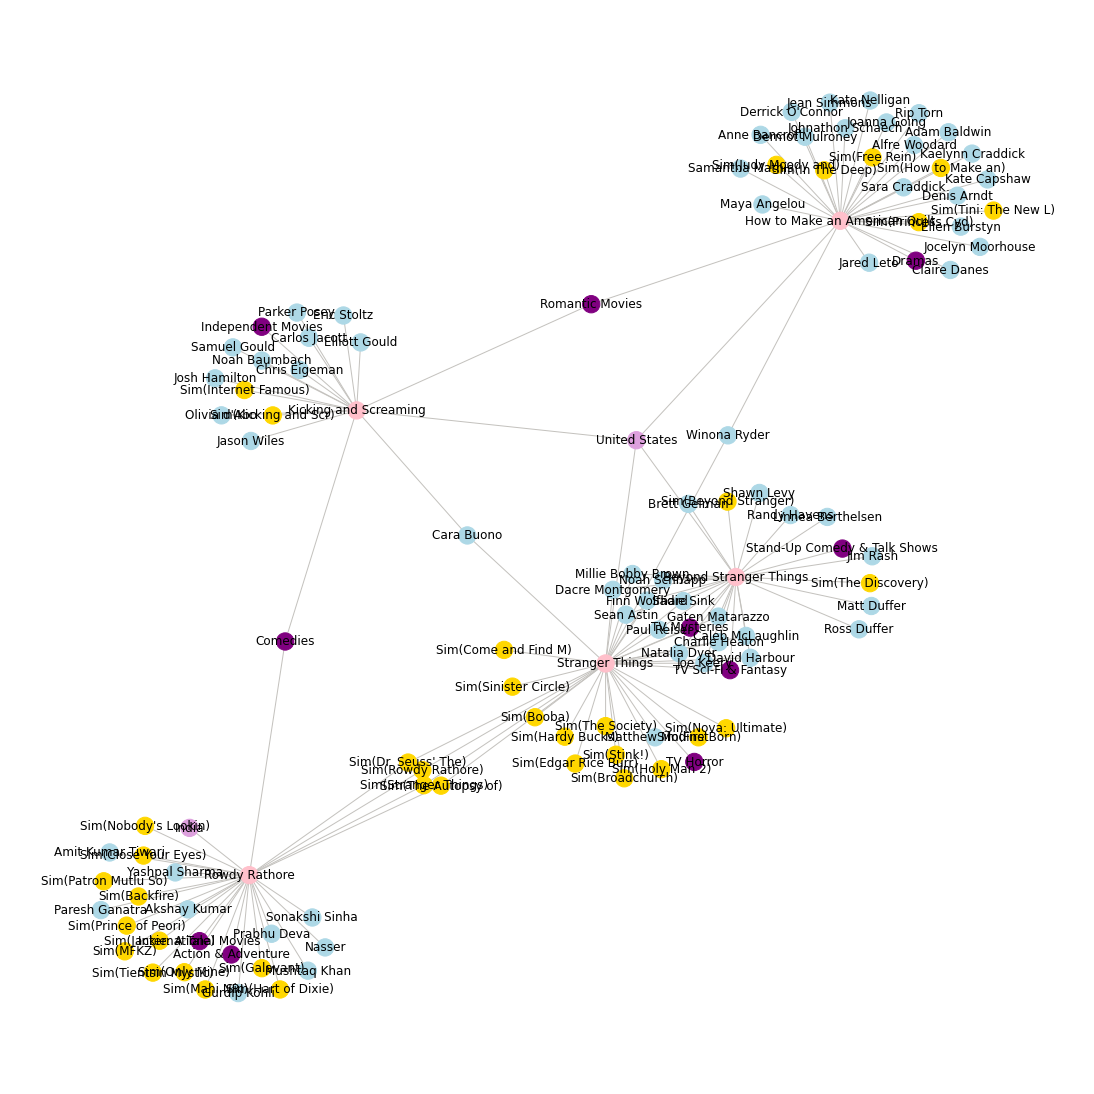

In [ ]:
recommend("Stranger Things")

In [ ]:
from matplotlib.ticker import StrMethodFormatter
print(movies.shape)   # return a tuple of columns and rows
print()
print(movies.dtypes)

(6234, 20)

show_id                  int64
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
year                   float64
month                  float64
day                    float64
directors               object
categories              object
actors                  object
countries               object
cluster                  int32
dtype: object


In [ ]:
rating_count=pd.DataFrame(movies['rating'].value_counts()).reset_index(inplace=False) 
rating_count.columns=['rating','count']
rating_count

,rating,count
0,TV-MA,2027
1,TV-14,1698
2,TV-PG,701
3,R,508
4,PG-13,286
5,NR,218
6,PG,184
7,TV-Y7,169
8,TV-G,149
9,TV-Y,143


In [ ]:
df_movies = (movies[movies['type'] == 'Movie']).reset_index()

Text(0.5, 1.0, 'Content Ratings on Netflix')

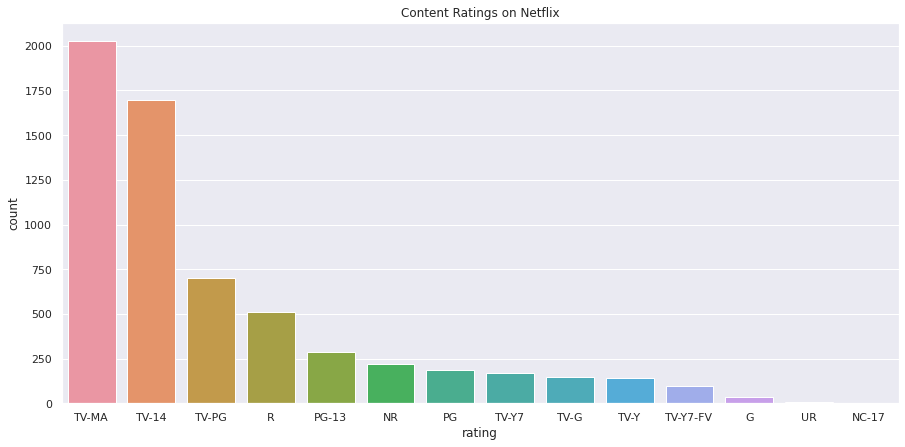

In [ ]:
#visualizing the ratings on the netflix dataset
sbn.set(rc={'figure.figsize':(15,7)})
ax=sbn.barplot(data=rating_count,x='rating',y='count')
ax.set_title("Content Ratings on Netflix")

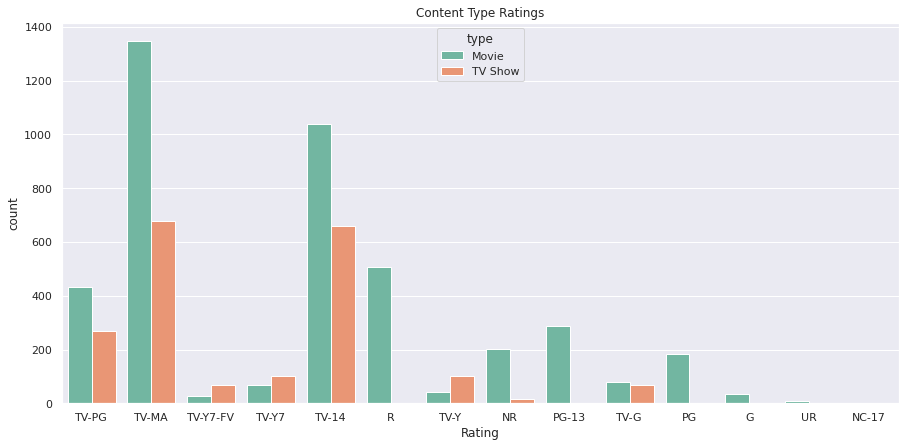

In [ ]:
#Checking the content types in each rating 
sbn.set_style(style = 'darkgrid')
sbn.set(rc={'figure.figsize':(15,7)})
ax = sbn.countplot(data = movies, x= 'rating',hue = 'type', palette='Set2')
ax.set_title('Content Type Ratings')
ax.set_xlabel('Rating')
ax.set_ylabel('count');

In [ ]:
#Categories of content mostly shown on Netflix
category=movies.set_index('title').listed_in.str.split(', ', expand=True).stack().reset_index(level=1, drop=True);
category

title
Norm of the North: King Sized Adventure        Children & Family Movies
Norm of the North: King Sized Adventure                        Comedies
Jandino: Whatever it Takes                              Stand-Up Comedy
Transformers Prime                                             Kids' TV
Transformers: Robots in Disguise                               Kids' TV
                                                         ...           
A Young Doctor's Notebook and Other Stories            British TV Shows
A Young Doctor's Notebook and Other Stories                 TV Comedies
A Young Doctor's Notebook and Other Stories                   TV Dramas
Friends                                               Classic & Cult TV
Friends                                                     TV Comedies
Length: 13670, dtype: object

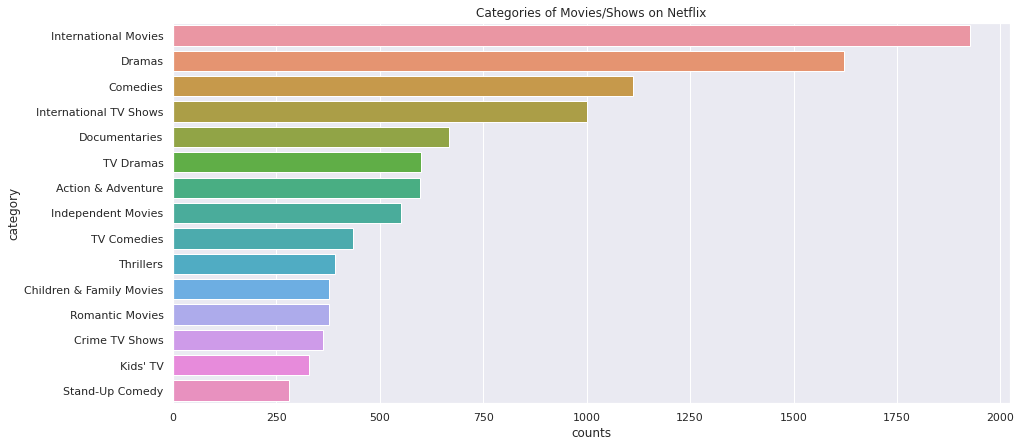

In [ ]:
#visualizing categories of movies mostly shown on Netflix
ax=sbn.countplot(y=category,order=category.value_counts().index[:15])
ax.set_title('Categories of Movies/Shows on Netflix')
ax.set_xlabel('counts')
ax.set_ylabel('category');